In [ ]:
!pip install dowhy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 6.4 MB/s eta 0:00:00


In [ ]:
!pip install econml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 10.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

import dowhy
from econml.dml import DML, LinearDML, SparseLinearDML, CausalForestDML

from sklearn.linear_model import (Lasso, LassoCV, LogisticRegression,
                                  LogisticRegressionCV,LinearRegression,
                                  MultiTaskElasticNet,MultiTaskElasticNetCV)
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures

#Causal graph

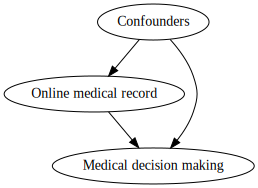

In [ ]:
import graphviz as gr
graph_general = gr.Digraph()

graph_general.edge("Online medical record", "Medical decision making")
graph_general.edge("Confounders", "Medical decision making")
graph_general.edge("Confounders", "Online medical record")

graph_general

#Upload data

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving raw_data.csv to raw_data.csv


In [ ]:
df0 = pd.read_csv('raw_data.csv')
df0.head(5)

Columns (337) have mixed types. Specify dtype option on import or set low_memory=False.


,HHID,PersonID,AdultsInHH,MailHHAdults,SeekHealthInfo,WhereSeekHealthInfo,WhoLookingFor,LotOfEffort,Frustrated,ConfidentGetHealthInf,...,HHAdultAge5,HHAdultMOB5,HHAdultGender6,HHAdultAge6,HHAdultMOB6,ChildrenInHH,RentOrOwn,IncomeRanges,IncomeFeelings,Prompt
0,91000002,91000002-02,1,2,2,-1,-1,-1,-1,3,...,-1,-1,-1,-1,-1,0,2,3,3,#NULL!
1,91000006,91000006-02,1,3,1,7,2,3,4,3,...,-1,-1,-1,-1,-1,-9,1,6,2,#NULL!
2,91000007,91000007-03,2,-1,1,7,3,4,4,2,...,-1,-1,-1,-1,-1,-9,-9,-9,-9,#NULL!
3,91000008,91000008-01,1,2,1,6,1,3,3,3,...,-1,-1,-1,-1,-1,0,1,4,1,#NULL!
4,91000012,91000012-01,1,2,1,7,3,4,4,1,...,-1,-1,-1,-1,-1,0,2,5,1,#NULL!


In [ ]:
df1 = df0[['Age','Race_Cat2','MaritalStatus','Education','SpeakEnglish','TotalHousehold','SelfGender','IncomeRanges','IncomeFeelings','AccessOnlineRecord','RecordsOnline_MakeDecision','UnderstandOnlineMedRec','UsefulOnlineMedRec','FreqGoProvider','GeneralHealth','MedConditions_Diabetes','MedConditions_HighBP','MedConditions_HeartCondition','MedConditions_LungDisease','MedConditions_Depression','LotOfEffort','Frustrated','ConfidentGetHealthInf','Electronic_SelfHealthInfo','Electronic_BuyMedicine','Electronic_TalkDoctor','Electronic_TrackedHealthCosts','Electronic_MadeAppts','Electronic_ECigHarms','UseInternet','Electronic_TestResults','HaveDevice_Tablet','HaveDevice_SmartPh']]
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5438 entries, 0 to 5437
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   Age                            5438 non-null   int64
 1   Race_Cat2                      5438 non-null   int64
 2   MaritalStatus                  5438 non-null   int64
 3   Education                      5438 non-null   int64
 4   SpeakEnglish                   5438 non-null   int64
 5   TotalHousehold                 5438 non-null   int64
 6   SelfGender                     5438 non-null   int64
 7   IncomeRanges                   5438 non-null   int64
 8   IncomeFeelings                 5438 non-null   int64
 9   AccessOnlineRecord             5438 non-null   int64
 10  RecordsOnline_MakeDecision     5438 non-null   int64
 11  UnderstandOnlineMedRec         5438 non-null   int64
 12  UsefulOnlineMedRec             5438 non-null   int64
 13  FreqGoProvider    

#Dealing with missing values

In [ ]:
# Remove missing, mis-report, and error values
df2_temp1 = df1[df1['AccessOnlineRecord'] >= 0]
df2_temp2_plus = df2_temp1[df2_temp1['RecordsOnline_MakeDecision'] > 0]
df2_temp2 = df2_temp2_plus[df2_temp2_plus['UnderstandOnlineMedRec'] > 0]
df2_temp3 = df2_temp2[df2_temp2['UsefulOnlineMedRec'] > 0]
df2_temp4 = df2_temp3[df2_temp3['FreqGoProvider'] >= 0]
df2_temp5 = df2_temp4[df2_temp4['GeneralHealth'] > 0]
df2_temp6 = df2_temp5[df2_temp5['LotOfEffort'] > 0]
df2_temp7 = df2_temp6[df2_temp6['Frustrated'] > 0]
df2_temp8 = df2_temp7[df2_temp7['ConfidentGetHealthInf'] > 0]
df2_temp9 = df2_temp8[df2_temp8['MedConditions_Diabetes'] > 0]
df2_temp10 = df2_temp9[df2_temp9['MedConditions_HighBP'] > 0]
df2_temp11 = df2_temp10[df2_temp10['MedConditions_HeartCondition'] > 0]
df2_temp12 = df2_temp11[df2_temp11['MedConditions_LungDisease'] > 0]
df2_temp13 = df2_temp12[df2_temp12['MedConditions_Depression'] > 0]
df2_temp14 = df2_temp13[df2_temp13['Electronic_SelfHealthInfo'] > 0]
df2_temp15 = df2_temp14[df2_temp14['Electronic_BuyMedicine'] > 0]
df2_temp16 = df2_temp15[df2_temp15['Electronic_TalkDoctor'] > 0]
df2_temp17 = df2_temp16[df2_temp16['Electronic_TrackedHealthCosts'] > 0]
df2_temp18 = df2_temp17[df2_temp17['Electronic_MadeAppts'] > 0]
df2_temp19 = df2_temp18[df2_temp18['Electronic_ECigHarms'] > 0]
df2_temp20 = df2_temp19[df2_temp19['Age'] >= 18]
df2_temp21 = df2_temp20[df2_temp20['MaritalStatus'] > 0]
df2_temp22 = df2_temp21[df2_temp21['Education'] > 0]
df2_temp23 = df2_temp22[df2_temp22['SpeakEnglish'] > 0]
df2_temp24 = df2_temp23[df2_temp23['TotalHousehold'] > 0]
df2_temp25 = df2_temp24[df2_temp24['SelfGender'] > 0]
df2_temp26 = df2_temp25[df2_temp25['IncomeRanges'] > 0]
df2_temp27 = df2_temp26[df2_temp26['IncomeFeelings'] > 0]
df2_temp28 = df2_temp27[df2_temp27['Race_Cat2'] > 0]
df2_temp29 = df2_temp28[df2_temp28['UseInternet'] > 0]
df2_temp30 = df2_temp29[df2_temp29['Electronic_TestResults'] > 0]
df2_temp31 = df2_temp30[df2_temp30['HaveDevice_Tablet'] > 0]
df2 = df2_temp31[df2_temp31['HaveDevice_SmartPh'] > 0]

df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1495 entries, 9 to 5435
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   Age                            1495 non-null   int64
 1   Race_Cat2                      1495 non-null   int64
 2   MaritalStatus                  1495 non-null   int64
 3   Education                      1495 non-null   int64
 4   SpeakEnglish                   1495 non-null   int64
 5   TotalHousehold                 1495 non-null   int64
 6   SelfGender                     1495 non-null   int64
 7   IncomeRanges                   1495 non-null   int64
 8   IncomeFeelings                 1495 non-null   int64
 9   AccessOnlineRecord             1495 non-null   int64
 10  RecordsOnline_MakeDecision     1495 non-null   int64
 11  UnderstandOnlineMedRec         1495 non-null   int64
 12  UsefulOnlineMedRec             1495 non-null   int64
 13  FreqGoProvider         

**Rename variables**

In [ ]:
df3 = df2.rename(columns={'AccessOnlineRecord':'AccessRecord','RecordsOnline_MakeDecision':'Records_MakeDec', 'SelfGender': 'Gender','Race_Cat2':'Race', 'MedConditions_HeartCondition':'MedCond_Heart','MedConditions_LungDisease':'MedCond_LungDis','MedConditions_Diabetes':'MedCond_Diabetes','MedConditions_HighBP':'MedCond_HighBP','MedConditions_Depression':'MedCond_Depres','Electronic_SelfHealthInfo':'Elect_HealthInfo','Electronic_BuyMedicine':'Elect_BuyMed','Electronic_TalkDoctor':'Elect_TalkDoctor','Electronic_TrackedHealthCosts':'Elect_TrackCosts','Electronic_MadeAppts':'Elect_MadeAppts','Electronic_ECigHarms':'Elect_ECigHarms','Electronic_TestResults':'Elect_TestResults','ConfidentGetHealthInf':'ConfGetHealthInf','UnderstandOnlineMedRec':'UnderstandMedRec','UsefulOnlineMedRec':'UsefulMedRec','HaveDevice_Tablet':'Device_Tablet','HaveDevice_SmartPh':'Device_SmartPh'})
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1495 entries, 9 to 5435
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Age                1495 non-null   int64
 1   Race               1495 non-null   int64
 2   MaritalStatus      1495 non-null   int64
 3   Education          1495 non-null   int64
 4   SpeakEnglish       1495 non-null   int64
 5   TotalHousehold     1495 non-null   int64
 6   Gender             1495 non-null   int64
 7   IncomeRanges       1495 non-null   int64
 8   IncomeFeelings     1495 non-null   int64
 9   AccessRecord       1495 non-null   int64
 10  Records_MakeDec    1495 non-null   int64
 11  UnderstandMedRec   1495 non-null   int64
 12  UsefulMedRec       1495 non-null   int64
 13  FreqGoProvider     1495 non-null   int64
 14  GeneralHealth      1495 non-null   int64
 15  MedCond_Diabetes   1495 non-null   int64
 16  MedCond_HighBP     1495 non-null   int64
 17  MedCond_Heart      

**Change "No" of RecordsOnline_MakeDecision from 2 to 0**

In [ ]:
df3[['Records_MakeDec']] = df3[['Records_MakeDec']].replace([2], [0]) #Replace 2 by 0 for interpretation purpose
df3.describe()

,Age,Race,MaritalStatus,Education,SpeakEnglish,TotalHousehold,Gender,IncomeRanges,IncomeFeelings,AccessRecord,...,Elect_HealthInfo,Elect_BuyMed,Elect_TalkDoctor,Elect_TrackCosts,Elect_MadeAppts,Elect_ECigHarms,UseInternet,Elect_TestResults,Device_Tablet,Device_SmartPh
count,1495.000000,1495.000000,1495.000000,1495.000000,1495.000000,1495.000000,1495.000000,1495.000000,1495.000000,1495.000000,...,1495.000000,1495.000000,1495.000000,1495.000000,1495.000000,1495.000000,1495.000000,1495.000000,1495.000000,1495.000000
mean,53.270903,12.565217,2.334448,5.732441,1.068896,2.427425,1.609365,6.442140,1.681605,1.989298,...,1.063545,1.561204,1.235452,1.389967,1.369900,1.887625,1.023411,1.157860,1.294983,1.060870
std,15.686121,5.205380,1.885401,1.230736,0.287983,1.286808,0.488056,1.923355,0.809269,1.038686,...,0.244023,0.496406,0.424423,0.487906,0.482939,0.315932,0.151257,0.364731,0.456188,0.239171
min,18.000000,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,40.000000,11.000000,1.000000,5.000000,1.000000,2.000000,1.000000,5.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000
50%,55.000000,11.000000,1.000000,6.000000,1.000000,2.000000,2.000000,7.000000,1.000000,2.000000,...,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000
75%,66.000000,11.000000,3.000000,7.000000,1.000000,3.000000,2.000000,8.000000,2.000000,3.000000,...,1.000000,2.000000,1.000000,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,1.000000
max,97.000000,52.000000,6.000000,7.000000,3.000000,9.000000,2.000000,9.000000,4.000000,4.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


**Convert "AccessOnlineRecord" to binary variable based on mean(also median in this case)**

In [ ]:
df3['AccessRecord2'] = (df3['AccessRecord'] >= 3).astype(int)
df3.head(10)

,Age,Race,MaritalStatus,Education,SpeakEnglish,TotalHousehold,Gender,IncomeRanges,IncomeFeelings,AccessRecord,...,Elect_BuyMed,Elect_TalkDoctor,Elect_TrackCosts,Elect_MadeAppts,Elect_ECigHarms,UseInternet,Elect_TestResults,Device_Tablet,Device_SmartPh,AccessRecord2
9,23,12,6,3,1,2,1,4,2,2,...,2,1,1,1,2,1,1,1,1,0
16,75,11,1,7,1,3,1,6,1,2,...,2,1,1,2,2,1,2,1,1,0
23,37,11,1,6,1,5,2,7,1,1,...,2,2,1,2,2,1,2,1,1,0
31,48,11,1,6,1,3,2,8,2,2,...,1,2,1,1,2,1,2,1,1,0
32,69,11,4,7,1,1,2,5,2,3,...,2,1,2,1,2,1,1,1,1,1
34,45,11,1,7,1,2,1,6,1,1,...,1,1,1,2,2,1,1,1,2,0
39,78,11,1,6,1,2,1,5,2,3,...,2,2,2,1,2,1,2,1,1,1
43,52,32,1,4,2,3,2,5,2,1,...,1,2,2,2,2,2,2,1,2,0
44,39,11,1,5,1,5,1,5,3,3,...,1,1,2,1,2,1,1,1,1,1
45,38,11,1,6,1,5,2,6,1,1,...,2,1,1,1,2,1,1,1,1,0


**Descriptive statistics (save)**

In [ ]:
df3.describe().to_csv('df3_descriptive_statistics.csv')

# EDA

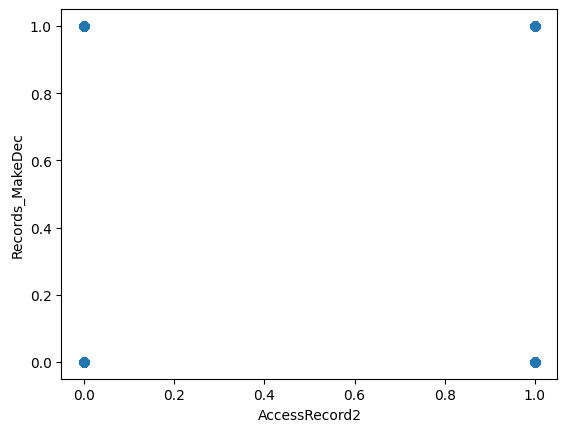

In [ ]:
# Scatterplot: AccessOnlineRecord2 vs. RecordsOnline_MakeDecision
plt.scatter(df3['AccessRecord2'], df3['Records_MakeDec'])
plt.xlabel('AccessRecord2')
plt.ylabel('Records_MakeDec')
plt.show()

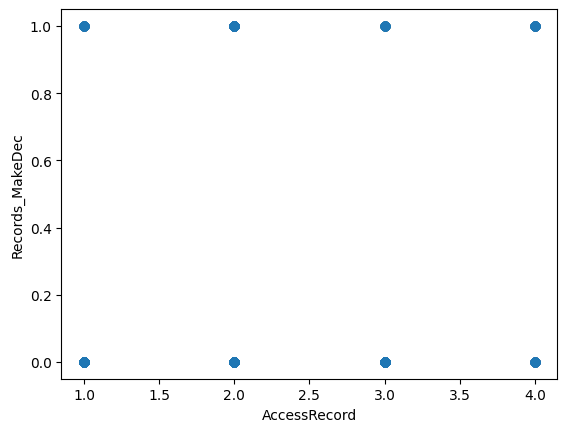

In [ ]:
# Scatterplot: AccessOnlineRecord vs. RecordsOnline_MakeDecision
plt.scatter(df3['AccessRecord'], df3['Records_MakeDec'])
plt.xlabel('AccessRecord')
plt.ylabel('Records_MakeDec')
plt.show()

###Histogram

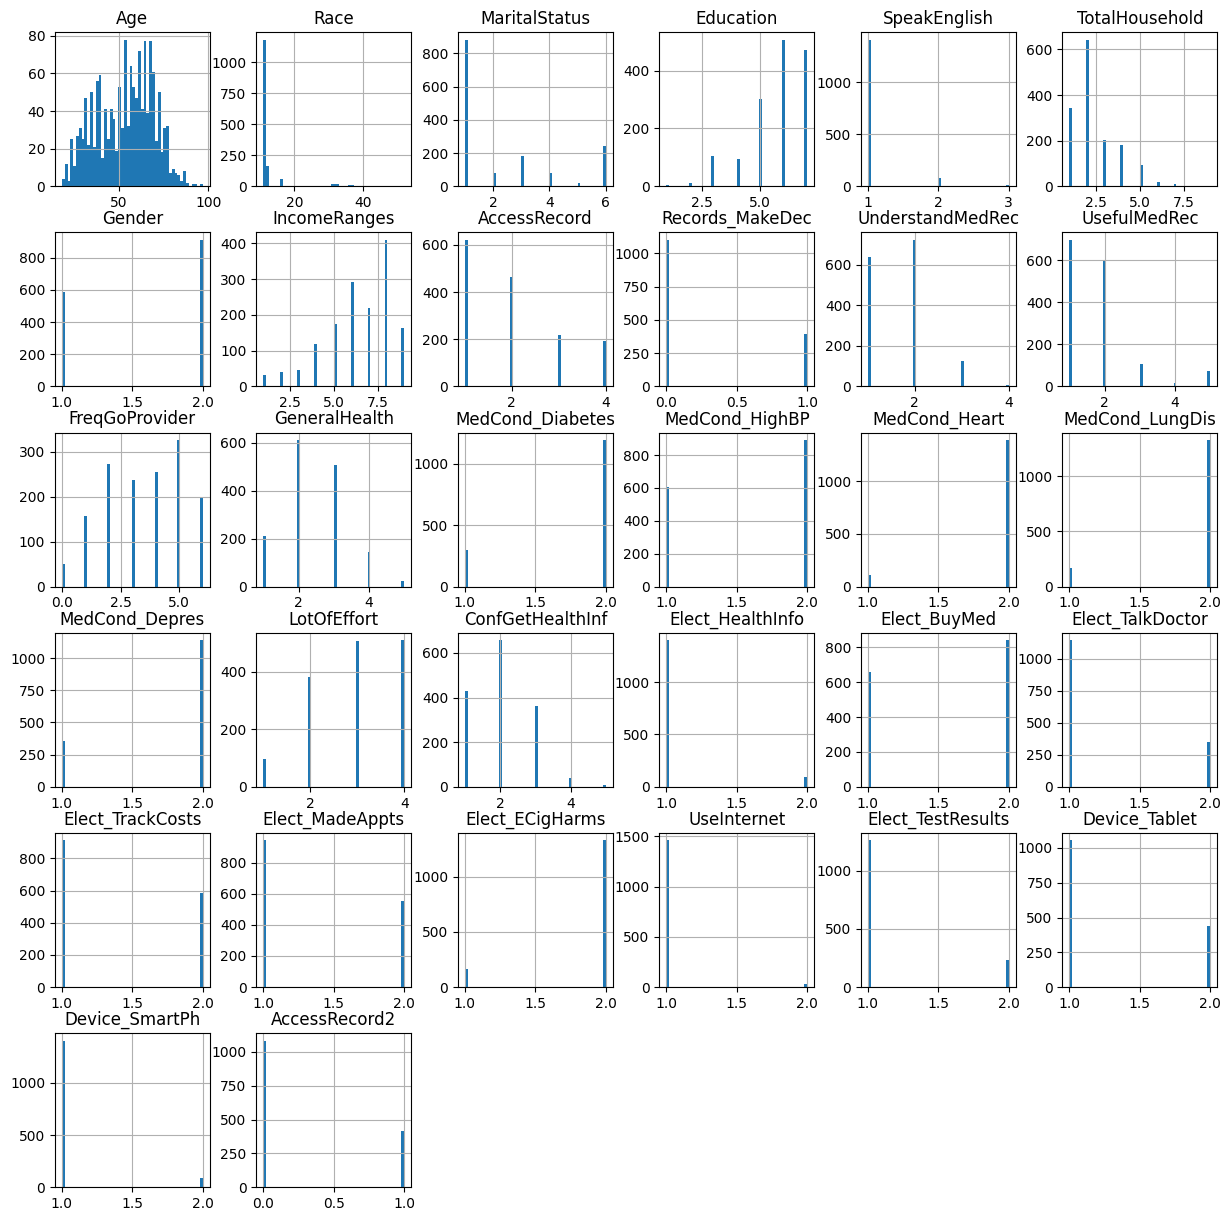

In [ ]:
#histogram
df_heatmap = df3.drop(['IncomeFeelings','Frustrated'], axis=1)

df_heatmap.hist(bins=50, figsize=(15,15))

# Save the histogram as an image file (e.g., PNG)
plt.savefig('histogram.png')

plt.show()

###Heatmap correlation

In [ ]:
df_heatmap = df3.drop(['AccessRecord','IncomeFeelings','Frustrated'], axis=1)
df_corr = df_heatmap.corr()

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5]),
 [Text(0, 0.5, 'Age'),
  Text(0, 1.5, 'Race'),
  Text(0, 2.5, 'MaritalStatus'),
  Text(0, 3.5, 'Education'),
  Text(0, 4.5, 'SpeakEnglish'),
  Text(0, 5.5, 'TotalHousehold'),
  Text(0, 6.5, 'Gender'),
  Text(0, 7.5, 'IncomeRanges'),
  Text(0, 8.5, 'Records_MakeDec'),
  Text(0, 9.5, 'UnderstandMedRec'),
  Text(0, 10.5, 'UsefulMedRec'),
  Text(0, 11.5, 'FreqGoProvider'),
  Text(0, 12.5, 'GeneralHealth'),
  Text(0, 13.5, 'MedCond_Diabetes'),
  Text(0, 14.5, 'MedCond_HighBP'),
  Text(0, 15.5, 'MedCond_Heart'),
  Text(0, 16.5, 'MedCond_LungDis'),
  Text(0, 17.5, 'MedCond_Depres'),
  Text(0, 18.5, 'LotOfEffort'),
  Text(0, 19.5, 'ConfGetHealthInf'),
  Text(0, 20.5, 'Elect_HealthInfo'),
  Text(0, 21.5, 'Elect_BuyMed'),
  Text(0, 22.5, 'Elect_TalkDoctor'),
  Text(0, 23.5, 'Elect_TrackC

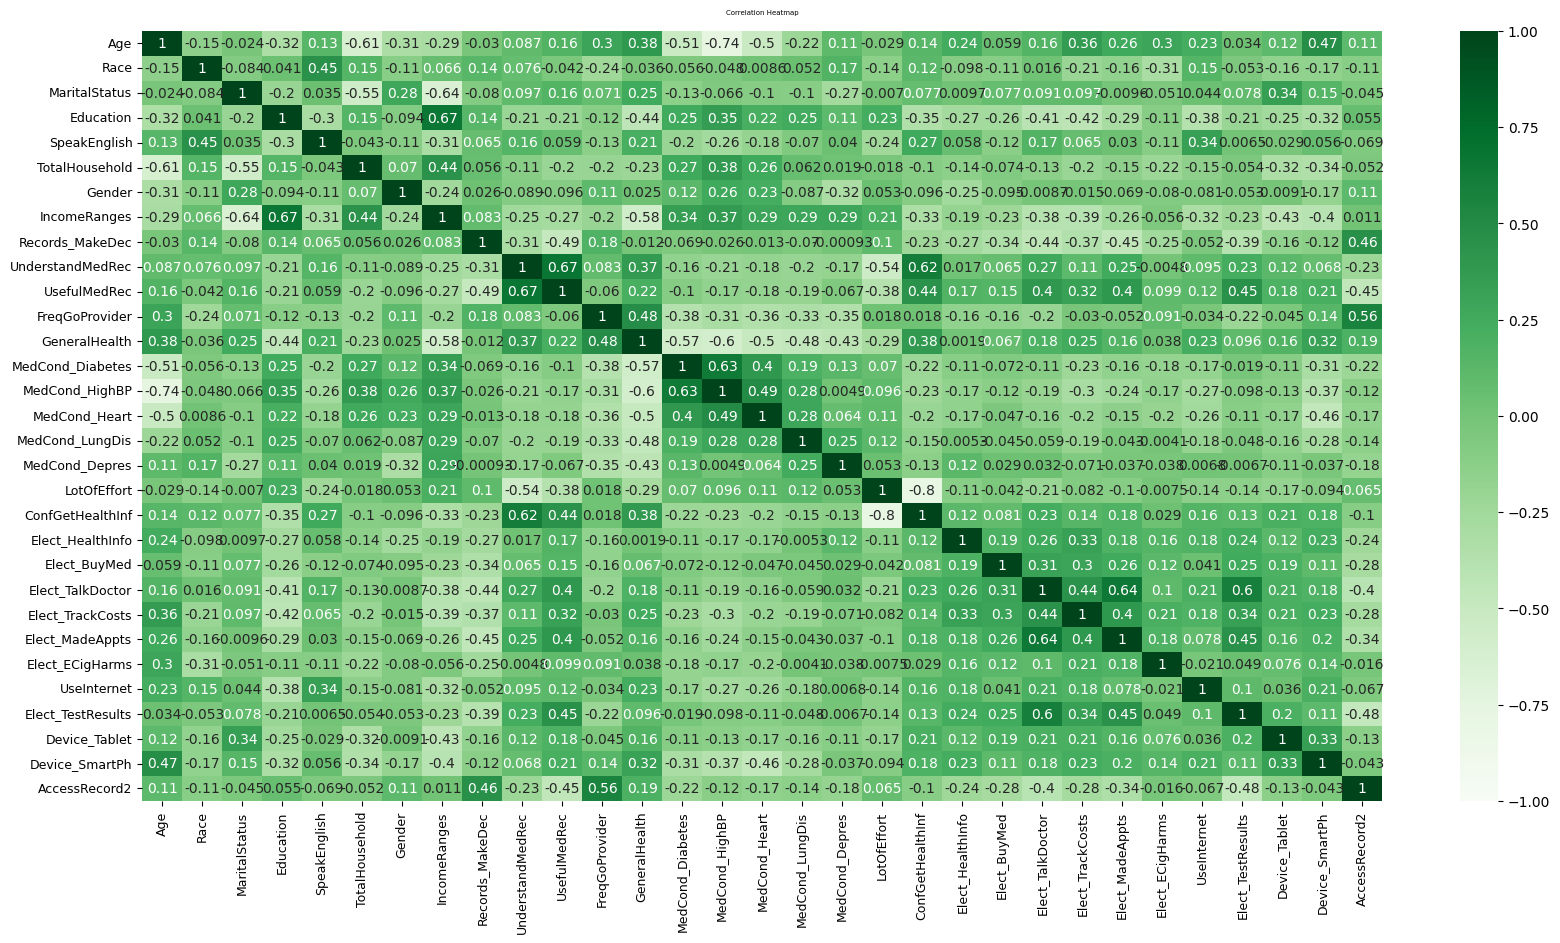

In [ ]:
import seaborn as sns
#sns.heatmap(df_corr.corr(), cmap="Greens")

# Altman's variables
plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(df_corr.corr(), vmin=-1, vmax=1, annot=True, cmap="Greens") #crest
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':5}, pad=12);

plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

#PART A: LINEAR REGRESSION

#Step 1: Causal graph

In [ ]:
df4 = df3.drop(['IncomeFeelings','Frustrated'], axis=1)
df4.info()

**Save data (for meta-learners)**

In [ ]:
df4.to_csv('df4_causalml.csv')

###General causal graph

In [ ]:
import graphviz as gr
graph_general = gr.Digraph()

graph_general.edge("Medical online record", "Medical making decision")
graph_general.edge("Confounders", "Medical making decision")
graph_general.edge("Confounders", "Medical online record")

graph_general

###Specific causal graph

In [ ]:
# g = """digraph {

# UnderstandMedRec;
# UsefulMedRec;
# FreqGoProvider;
# GeneralHealth;
# MedCond_Diabetes;
# MedCond_HighBP;
# MedCond_Heart;
# MedCond_LungDis;
# MedCond_Depres;
# LotOfEffort;
# Frustrated;
# ConfGetHealthInf;
# Elect_HealthInfo;
# Elect_BuyMed;
# Elect_TalkDoctor;
# Elect_TrackCosts;
# Elect_MadeAppts;
# Elect_ECigHarms;
# Elect_TestResults;
# Age;
# Race;
# Gender;
# MaritalStatus;
# Education;
# SpeakEnglish;
# TotalHousehold;
# IncomeRanges;
# IncomeFeelings;
# UseInternet;
# Device_Tablet;
# Device_SmartPh;

# UnderstandMedRec -> AccessRecord2; UnderstandMedRec -> Records_MakeDec;
# UsefulMedRec -> AccessRecord2; UsefulMedRec -> Records_MakeDec;
# FreqGoProvider -> AccessRecord2; FreqGoProvider -> Records_MakeDec;
# GeneralHealth -> AccessRecord2; GeneralHealth -> Records_MakeDec;
# MedCond_Diabetes -> AccessRecord2; MedCond_Diabetes -> Records_MakeDec;
# MedCond_HighBP -> AccessRecord2; MedCond_HighBP -> Records_MakeDec;
# MedCond_Heart -> AccessRecord2; MedCond_Heart -> Records_MakeDec;
# MedCond_LungDis -> AccessRecord2; MedCond_LungDis -> Records_MakeDec;
# MedCond_Depres -> AccessRecord2; MedCond_Depres -> Records_MakeDec;
# LotOfEffort -> AccessRecord2; LotOfEffort -> Records_MakeDec;
# Frustrated -> AccessRecord2; Frustrated -> Records_MakeDec;
# ConfGetHealthInf -> AccessRecord2; ConfGetHealthInf -> Records_MakeDec;
# Elect_HealthInfo -> AccessRecord2; Elect_HealthInfo -> Records_MakeDec;
# Elect_BuyMed -> AccessRecord2; Elect_BuyMed -> Records_MakeDec;
# Elect_TalkDoctor -> AccessRecord2; Elect_TalkDoctor -> Records_MakeDec;
# Elect_TrackCosts -> AccessRecord2; Elect_TrackCosts -> Records_MakeDec;
# Elect_MadeAppts -> AccessRecord2; Elect_MadeAppts -> Records_MakeDec;
# Elect_ECigHarms -> AccessRecord2; Elect_ECigHarms -> Records_MakeDec;
# Elect_TestResults -> AccessRecord2; Elect_TestResults -> Records_MakeDec;

# Age -> AccessRecord2; Age -> Records_MakeDec;
# Race -> AccessRecord2; Race -> Records_MakeDec;
# Gender -> AccessRecord2; Gender -> Records_MakeDec;
# MaritalStatus -> AccessRecord2; MaritalStatus -> Records_MakeDec;
# Education -> AccessRecord2; Education -> Records_MakeDec;
# SpeakEnglish -> AccessRecord2; SpeakEnglish -> Records_MakeDec;
# TotalHousehold -> AccessRecord2; TotalHousehold -> Records_MakeDec;
# IncomeRanges -> AccessRecord2; IncomeRanges -> Records_MakeDec;
# IncomeFeelings -> AccessRecord2; IncomeFeelings -> Records_MakeDec;
# UseInternet -> AccessRecord2; UseInternet -> Records_MakeDec;
# Device_Tablet -> AccessRecord2; Device_Tablet -> Records_MakeDec;
# Device_SmartPh -> AccessRecord2; Device_SmartPh -> Records_MakeDec;

# AccessRecord2 -> Records_MakeDec;

# }"""

In [ ]:
g = """digraph {

AccessRecord2;
Records_MakeDec;

UnderstandMedRec;
UsefulMedRec;
FreqGoProvider;
GeneralHealth;
MedCond_Diabetes;
MedCond_HighBP;
MedCond_Heart;
MedCond_LungDis;
MedCond_Depres;
LotOfEffort;
ConfGetHealthInf;
Elect_HealthInfo;
Elect_BuyMed;
Elect_TalkDoctor;
Elect_TrackCosts;
Elect_MadeAppts;
Elect_ECigHarms;
Elect_TestResults;
Age;
Race;
Gender;
MaritalStatus;
Education;
SpeakEnglish;
TotalHousehold;
IncomeRanges;
UseInternet;
Device_Tablet;
Device_SmartPh;

UnderstandMedRec -> AccessRecord2; UnderstandMedRec -> Records_MakeDec;
UsefulMedRec -> AccessRecord2; UsefulMedRec -> Records_MakeDec;
FreqGoProvider -> AccessRecord2; FreqGoProvider -> Records_MakeDec;
GeneralHealth -> AccessRecord2; GeneralHealth -> Records_MakeDec;
MedCond_Diabetes -> AccessRecord2; MedCond_Diabetes -> Records_MakeDec;
MedCond_HighBP -> AccessRecord2; MedCond_HighBP -> Records_MakeDec;
MedCond_Heart -> AccessRecord2; MedCond_Heart -> Records_MakeDec;
MedCond_LungDis -> AccessRecord2; MedCond_LungDis -> Records_MakeDec;
MedCond_Depres -> AccessRecord2; MedCond_Depres -> Records_MakeDec;
LotOfEffort -> AccessRecord2; LotOfEffort -> Records_MakeDec;
ConfGetHealthInf -> AccessRecord2; ConfGetHealthInf -> Records_MakeDec;
Elect_HealthInfo -> AccessRecord2; Elect_HealthInfo -> Records_MakeDec;
Elect_BuyMed -> AccessRecord2; Elect_BuyMed -> Records_MakeDec;
Elect_TalkDoctor -> AccessRecord2; Elect_TalkDoctor -> Records_MakeDec;
Elect_TrackCosts -> AccessRecord2; Elect_TrackCosts -> Records_MakeDec;
Elect_MadeAppts -> AccessRecord2; Elect_MadeAppts -> Records_MakeDec;
Elect_ECigHarms -> AccessRecord2; Elect_ECigHarms -> Records_MakeDec;
Elect_TestResults -> AccessRecord2; Elect_TestResults -> Records_MakeDec;

Age -> AccessRecord2; Age -> Records_MakeDec;
Race -> AccessRecord2; Race -> Records_MakeDec;
Gender -> AccessRecord2; Gender -> Records_MakeDec;
MaritalStatus -> AccessRecord2; MaritalStatus -> Records_MakeDec;
Education -> AccessRecord2; Education -> Records_MakeDec;
SpeakEnglish -> AccessRecord2; SpeakEnglish -> Records_MakeDec;
TotalHousehold -> AccessRecord2; TotalHousehold -> Records_MakeDec;
IncomeRanges -> AccessRecord2; IncomeRanges -> Records_MakeDec;
UseInternet -> AccessRecord2; UseInternet -> Records_MakeDec;
Device_Tablet -> AccessRecord2; Device_Tablet -> Records_MakeDec;
Device_SmartPh -> AccessRecord2; Device_SmartPh -> Records_MakeDec;

AccessRecord2 -> Records_MakeDec;

}"""

In [ ]:
from dowhy import CausalModel

treatment = ['AccessRecord2']
outcome = 'Records_MakeDec'

model = CausalModel(
    data = df4,
    treatment = treatment,
    outcome = outcome,
    graph = g) #confounders (X) and controls (W). Note on X vs. W https://econml.azurewebsites.net/spec/api.html

model.view_model()

#Step 2: Identify (Identification)

In [ ]:
# Step 2: IDENTIFY effect (using identify_effect function and backdoor estimator)
# Identify 'estimand'
est_identify = model.identify_effect(proceed_when_unidentifiable=True, method_name='exhaustive-search')

print(est_identify)

#Step 3: Estimate

**Linear regression**

In [ ]:
est_linreg = model.estimate_effect(est_identify, method_name='backdoor.linear_regression', test_significance=True,  confidence_intervals=True, target_units='ate') #default: target_units='ate'
print(est_linreg)

In [ ]:
# #NEW
# Mean value: 0.13282427341894035
# p-value: [5.67685536e-07]
# 95.0% confidence interval: [[0.08096612 0.18468243]]

In [ ]:
# Mean value: 0.13392098224309212
# p-value: [4.66815478e-07]
# 95.0% confidence interval: [[0.08202811 0.18581386]]

**Estimation (PSM)**

In [ ]:
est_PSM = model.estimate_effect(est_identify, method_name='backdoor.propensity_score_matching', test_significance=True, confidence_intervals=True, target_units='ate')
print(est_PSM)

In [ ]:
# #NEW
# Mean value: 0.12709030100334448
# p-value: 0.0020000000000000018
# 95.0% confidence interval: (0.009364548494983277, 0.1906354515050167)

In [ ]:
# Mean value: 0.1177257525083612
# p-value: 0.006000000000000005
# 95.0% confidence interval: (-0.0053511705685618804, 0.17859531772575252)

**Estimation (PSS)**

In [ ]:
est_PSS = model.estimate_effect(est_identify, method_name='backdoor.propensity_score_stratification', test_significance=True, confidence_intervals=True, target_units='ate')
print(est_PSS)

In [ ]:
# #NEW
# Mean value: 0.1275274841863438
# p-value: [0, 0.001]
# 95.0% confidence interval: (0.04443156136128559, 0.20542876039238578)

In [ ]:
# ## Estimate
# Mean value: 0.13780613665684138
# p-value: [0, 0.001]
# 95.0% confidence interval: (0.07894335772791192, 0.21415272567539503)

**Estimation (distance matching)**

In [ ]:
est_PSDM = model.estimate_effect(est_identify, method_name='backdoor.distance_matching', method_params={'distance_metric':"minkowski", 'p':2} ,test_significance=True, confidence_intervals=True, target_units='ate')
print(est_PSDM)

In [ ]:
# #NEW
# Mean value: 0.1939799331103679
# p-value: [0, 0.001]
# 95.0% confidence interval: (0.13913043478260873, 0.25083612040133785)

In [ ]:
# ## Estimate
# Mean value: 0.18996655518394648
# p-value: [0, 0.001]
# 95.0% confidence interval: (0.12441471571906354, 0.25083612040133774)

**Estimation (PSW)**

In [ ]:
est_PSW = model.estimate_effect(est_identify, method_name='backdoor.propensity_score_weighting' ,test_significance=True, confidence_intervals=True, target_units='ate')
print(est_PSW)

In [ ]:
# # NEW
# Mean value: 0.12622787247092074
# p-value: [0, 0.001]
# 95.0% confidence interval: (0.059961599320518366, 0.1973575889425532)

In [ ]:
# ## Estimate
# Mean value: 0.12357507968375678
# p-value: [0, 0.001]
# 95.0% confidence interval: (0.058466254105783155, 0.1867990012278441)

#Step 4: Refuter (for linear regression)

**PLACEBO REFUTER (replace treatment with a random feature)**

In [ ]:
val_est_placebo = model.refute_estimate(est_identify, est_linreg, method_name="placebo_treatment_refuter", placebo_type="permute",num_simulations=20)
print(val_est_placebo)

In [ ]:
# #NEW
# Refute: Use a Placebo Treatment
# Estimated effect:0.13282427341894035
# New effect:-0.003961421647791496
# p value:0.44605817748058063

In [ ]:
# Refute: Use a Placebo Treatment
# Estimated effect:0.13392098224309212
# New effect:-0.011477229985719041
# p value:0.27058357757484097

**DATA SUBSET REFUTER 20% (run code with randomly subset of the 20% of the original data)**

In [ ]:
val_est_data_subset_20 = model.refute_estimate(est_identify, est_linreg, method_name="data_subset_refuter", subset_fraction=0.2, num_simulations=20)
print(val_est_data_subset_20)

In [ ]:
# # NEW
# Refute: Use a subset of data
# Estimated effect:0.13282427341894035
# New effect:0.13835915852130676
# p value:0.46339506094724314

In [ ]:
# Refute: Use a subset of data
# Estimated effect:0.13392098224309212
# New effect:0.15237006745980808
# p value:0.39523052333589215

**DATA SUBSET REFUTER 50% (run code with randomly subset of the 50% of the original data)**

In [ ]:
val_est_data_subset_50 = model.refute_estimate(est_identify, est_linreg, method_name="data_subset_refuter", subset_fraction=0.5, num_simulations=20)
print(val_est_data_subset_50)

In [ ]:
# #NEW
# Refute: Use a subset of data
# Estimated effect:0.13282427341894035
# New effect:0.12121643473761183
# p value:0.27056044091973797

In [ ]:
# Refute: Use a subset of data
# Estimated effect:0.13392098224309212
# New effect:0.12355782535558435
# p value:0.34910740978563903

**DATA SUBSET REFUTER 80% (run code with randomly subset of the 80% of the original data)**

In [ ]:
val_est_data_subset_80 = model.refute_estimate(est_identify, est_linreg, method_name="data_subset_refuter", subset_fraction=0.8, num_simulations=20)
print(val_est_data_subset_80)

In [ ]:
# #NEW
# Refute: Use a subset of data
# Estimated effect:0.13282427341894035
# New effect:0.1344272219792829
# p value:0.4597007867526454

In [ ]:
# Refute: Use a subset of data
# Estimated effect:0.13392098224309212
# New effect:0.127208929061222
# p value:0.2940748870575076

**DATA SUBSET REFUTER 90% (run code with randomly subset of the 90% of the original data)**

In [ ]:
val_est_data_subset_90 = model.refute_estimate(est_identify, est_linreg, method_name="data_subset_refuter", subset_fraction=0.9, num_simulations=20)
print(val_est_data_subset_90)

In [ ]:
# Refute: Use a subset of data
# Estimated effect:0.13282427341894035
# New effect:0.13218254880486344
# p value:0.4666232651877046

#Step 4: Refuter (for PSM)

**PLACEBO REFUTER (replace treatment with a random feature)**

In [ ]:
val_est_placebo_PSM = model.refute_estimate(est_identify, est_PSM, method_name="placebo_treatment_refuter", placebo_type="permute",num_simulations=20)
print(val_est_placebo_PSM)

In [ ]:
# #NEW
# Refute: Use a Placebo Treatment
# Estimated effect:0.12709030100334448
# New effect:-0.005585284280936455
# p value:0.44164745551135354

**DATA SUBSET REFUTER 20% (run code with randomly subset of the 20% of the original data)**

In [ ]:
val_est_data_subset_20_PSM = model.refute_estimate(est_identify, est_PSM, method_name="data_subset_refuter", subset_fraction=0.2, num_simulations=20)
print(val_est_data_subset_20_PSM)

In [ ]:
# #NEW
# Refute: Use a subset of data
# Estimated effect:0.12709030100334448
# New effect:0.1548494983277592
# p value:0.39029142348811596

**DATA SUBSET REFUTER 50% (run code with randomly subset of the 50% of the original data)**

In [ ]:
val_est_data_subset_50_PSM = model.refute_estimate(est_identify, est_PSM, method_name="data_subset_refuter", subset_fraction=0.5, num_simulations=20)
print(val_est_data_subset_50_PSM)

In [ ]:
# #NEW
# Refute: Use a subset of data
# Estimated effect:0.12709030100334448
# New effect:0.12399732620320858
# p value:0.4783221388524326

**DATA SUBSET REFUTER 80% (run code with randomly subset of the 80% of the original data)**

In [ ]:
val_est_data_subset_80_PSM = model.refute_estimate(est_identify, est_PSM, method_name="data_subset_refuter", subset_fraction=0.8, num_simulations=20)
print(val_est_data_subset_80_PSM)

In [ ]:
# #NEW
# Refute: Use a subset of data
# Estimated effect:0.12709030100334448
# New effect:0.15581103678929767
# p value:0.28750888136618746

**DATA SUBSET REFUTER 90% (run code with randomly subset of the 90% of the original data)**

In [ ]:
val_est_data_subset_90_PSM = model.refute_estimate(est_identify, est_PSM, method_name="data_subset_refuter", subset_fraction=0.9, num_simulations=20)
print(val_est_data_subset_90_PSM)

In [ ]:
# #NEW
# Refute: Use a subset of data
# Estimated effect:0.12709030100334448
# New effect:0.14461367013372958
# p value:0.3778449575145531

#Step 4: Refuter (for PSW)

**PLACEBO REFUTER (replace treatment with a random feature)**

In [ ]:
val_est_placebo_PSW = model.refute_estimate(est_identify, est_PSW, method_name="placebo_treatment_refuter", placebo_type="permute",num_simulations=20)
print(val_est_placebo_PSW)

In [ ]:
# #NEW
# Refute: Use a Placebo Treatment
# Estimated effect:0.12622787247092074
# New effect:-0.12215523345962273
# p value:2.0011070578362933e-09

In [ ]:
# Refute: Use a Placebo Treatment
# Estimated effect:0.12335651124380581
# New effect:-0.11660229298423293
# p value:3.800248360219527e-06

**DATA SUBSET REFUTER 20% (run code with randomly subset of the 20% of the original data)**

In [ ]:
val_est_data_subset_20_PSW = model.refute_estimate(est_identify, est_PSW, method_name="data_subset_refuter", subset_fraction=0.2, num_simulations=20)
print(val_est_data_subset_20_PSW)

In [ ]:
# #NEW
# Refute: Use a subset of data
# Estimated effect:0.12622787247092074
# New effect:0.09895347110403133
# p value:0.3139030613461571

In [ ]:
# Refute: Use a subset of data
# Estimated effect:0.12335651124380581
# New effect:0.12334075363925938
# p value:0.49991917361158755

**DATA SUBSET REFUTER 50% (run code with randomly subset of the 50% of the original data)**

In [ ]:
val_est_data_subset_50_PSW = model.refute_estimate(est_identify, est_PSW, method_name="data_subset_refuter", subset_fraction=0.5, num_simulations=20)
print(val_est_data_subset_50_PSW)

In [ ]:
# #NEW
# Refute: Use a subset of data
# Estimated effect:0.12622787247092074
# New effect:0.1309776255842901
# p value:0.4319966773910101

In [ ]:
# Refute: Use a subset of data
# Estimated effect:0.12335651124380581
# New effect:0.129399516243502
# p value:0.4104054119800979

**DATA SUBSET REFUTER 80% (run code with randomly subset of the 80% of the original data)**

In [ ]:
val_est_data_subset_80_PSW = model.refute_estimate(est_identify, est_PSW, method_name="data_subset_refuter", subset_fraction=0.8, num_simulations=20)
print(val_est_data_subset_80_PSW)

In [ ]:
# #NEW
# Refute: Use a subset of data
# Estimated effect:0.12622787247092074
# New effect:0.12421495160498155
# p value:0.449825330600364

In [ ]:
# Refute: Use a subset of data
# Estimated effect:0.12335651124380581
# New effect:0.12214077603425003
# p value:0.4655149740589182

#Shapley additive explanations (SHAP)

In [ ]:
!pip install shap

In [ ]:
import sklearn
import shap

In [ ]:
X_SHAP = df4[['UnderstandMedRec','UsefulMedRec','FreqGoProvider','GeneralHealth','MedCond_Diabetes','MedCond_HighBP','MedCond_Heart','MedCond_LungDis','MedCond_Depres','LotOfEffort','ConfGetHealthInf','Elect_HealthInfo','Elect_BuyMed','Elect_TalkDoctor','Elect_TrackCosts','Elect_MadeAppts','Elect_ECigHarms','Elect_TestResults','Age','Race','Gender','MaritalStatus','Education','SpeakEnglish','TotalHousehold','IncomeRanges','UseInternet','Device_Tablet','Device_SmartPh']]
y_SHAP = df4['Records_MakeDec']

###Linear regression model

In [ ]:
model_shap = sklearn.linear_model.LinearRegression()
model_shap.fit(X_SHAP, y_SHAP)

###Examining the model coefficients

In [ ]:
 print("Model coefficients:\n")
for i in range(X_SHAP.shape[1]):
    print(X_SHAP.columns[i], "=", model_shap.coef_[i].round(5))

In [ ]:
# Compute the SHAP values for the linear model
explainer = shap.Explainer(model_shap.predict, X_SHAP)
shap_values = explainer(X_SHAP)

# Make a standard partial dependence plot
sample_ind = 20
shap.partial_dependence_plot(
    "GeneralHealth",
    model_shap.predict,
    X_SHAP,
    model_expected_value=True,
    feature_expected_value=True,
    ice=False,
    shap_values=shap_values[sample_ind : sample_ind + 1, :],
)

**Global measure of feature importance**

In [ ]:
# plt.savefig('histogram.png')

# plt.show()

In [ ]:
# By default a SHAP bar plot will take the mean absolute value of each feature over all the instances (rows) of the dataset
shap.plots.bar(shap_values, max_display=20)

plt.savefig('shap_bar.png')

#plt.show()

In [ ]:
# Using a beeswarm plot to summarize the entire distribution of SHAP values for each feature
shap.plots.beeswarm(shap_values, max_display=20)

**Local feature importance**

In [ ]:
# The additive nature of Shapley values
# The waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[sample_ind], max_display=20)

#Logistic regression

In [ ]:
X_logit = df3[['AccessRecord2','UnderstandMedRec','UsefulMedRec','FreqGoProvider','GeneralHealth','MedCond_Diabetes','MedCond_HighBP','MedCond_Heart','MedCond_LungDis','MedCond_Depres','LotOfEffort','ConfGetHealthInf','Elect_HealthInfo','Elect_BuyMed','Elect_TalkDoctor','Elect_TrackCosts','Elect_MadeAppts','Elect_ECigHarms','Elect_TestResults','Age','Race','Gender','MaritalStatus','Education','SpeakEnglish','TotalHousehold','IncomeRanges','UseInternet','Device_Tablet','Device_SmartPh']]
X_logit = sm.add_constant(X_logit)
y_logit = df3['Records_MakeDec']

In [ ]:
# Split data into train and test set
X_logit_train, X_logit_test, y_logit_train, y_logit_test = train_test_split(X_logit, y_logit, test_size=.2)

In [ ]:
# Get model, then coefficients
model = sm.Logit(y_logit_train, X_logit_train)
result = model.fit(method='newton')

result.params #log odds

**Get odd ratios (OR)**

In [ ]:
model_odds = pd.DataFrame(np.exp(result.params), columns= ['OR'])
model_odds['z-value']= result.pvalues
model_odds[['2.5%', '97.5%']] = np.exp(result.conf_int())

model_odds #Odds ratio

In [ ]:
# check
import math
math.log(1.911288)

In [ ]:
math.log(1.002267)

In [ ]:
math.log(0.001001)

In [ ]:
1.911288/(1+1.911288) #probability

In [ ]:
result.predict(X_logit_test)

(result.predict(X_logit_test) >= 0.5).astype(int)

In [ ]:
# Predictive confusion matrix
result.pred_table()

In [ ]:
result.summary()

#Double machine learning

In [ ]:
Y = df3['Records_MakeDec']
T = df3['AccessRecord2']
X = df3[['UnderstandMedRec','UsefulMedRec','FreqGoProvider','GeneralHealth','MedCond_Diabetes','MedCond_HighBP','MedCond_Heart','MedCond_LungDis','MedCond_Depres','LotOfEffort','ConfGetHealthInf','Elect_HealthInfo','Elect_BuyMed','Elect_TalkDoctor','Elect_TrackCosts','Elect_MadeAppts','Elect_ECigHarms','Elect_TestResults','Age','Race','Gender','MaritalStatus','Education','SpeakEnglish','TotalHousehold','IncomeRanges','UseInternet','Device_Tablet','Device_SmartPh']]

In [ ]:
# Split the data into train/test set
Y_train, Y_test, T_train, T_test, X_train, X_test = train_test_split(Y, T, X, test_size=.2)

###Estimation (Linear DML)

In [ ]:
# The model
# default: est = LinearDML()
# Ref for parameters: https://econml.azurewebsites.net/_autosummary/econml.dml.LinearDML.html
est_linear_DML_1 = LinearDML(model_y = RandomForestRegressor(), #the estimator for fitting the response Y to the features X
                model_t = RandomForestRegressor(), #the estimator for fitting the treatment T to the features X
                random_state = 123)

# Fitting the model
est_linear_DML_1.fit(Y_train, T_train, X=X_train, inference='statsmodels')

In [ ]:
# Get the effect inference summary, which includes the standard error, z test score, p value, and confidence interval given each sample X[i]
est_linear_DML_1.effect_inference(X_test).summary_frame(alpha=0.05, value=0, decimals=3)

In [ ]:
# Get the population summary for the entire sample X
est_linear_DML_1.effect_inference(X_test).population_summary(alpha=0.1, value=0, decimals=6, tol=0.001)

In [ ]:
# #NEW
# Uncertainty of Mean Point Estimate
# mean_point	stderr_mean	zstat	pvalue	ci_mean_lower	ci_mean_upper
# 0.14646	0.034969	4.188329	2.8e-05	0.088942	0.203978
# Distribution of Point Estimate
# std_point	pct_point_lower	pct_point_upper
# 0.194785	-0.15486	0.469932
# Total Variance of Point Estimate
# stderr_point	ci_point_lower	ci_point_upper
# 0.197899	-0.281179	0.575048

In [ ]:
# mean_point	stderr_mean	zstat	pvalue	ci_mean_lower	ci_mean_upper
# 0.163961	0.035755	4.585611	5e-06	0.105148	0.222773
# Distribution of Point Estimate
# std_point	pct_point_lower	pct_point_upper
# 0.207999	-0.170871	0.511729
# Total Variance of Point Estimate
# stderr_point	ci_point_lower	ci_point_upper
# 0.21105	-0.279134	0.629906

In [ ]:
#  Get the parameter inference summary for the final model
est_linear_DML_1.summary(decimals=6)

###Estimation (Causal forest DML)

In [ ]:
# The Causal Forest model
est_CF_1 = CausalForestDML(model_y=RandomForestRegressor(), #OR model_y=LassoCV()
                       model_t=RandomForestRegressor(), #OR model_t=LassoCV()
                       criterion='mse', n_estimators=1000, #OR criterion='het' (heterogeneity score)
                       min_samples_leaf=10,
                       max_depth=10, max_samples=0.5,
                       min_impurity_decrease=0.001,
                       random_state=123)
# For more parameters, see https://econml.azurewebsites.net/_autosummary/econml.grf.CausalForest.html

# Fitting the model
est_CF_1.fit(Y_train, T_train, X=X_train, cache_values=True) #OR est4.fit(Y, T, X=X, W=W, cache_values=True) for entire data

In [ ]:
# Get the effect inference summary, which includes the standard error, z test score, p value, and confidence interval given each sample X[i]
est_CF_1.effect_inference(X_test).summary_frame(alpha=0.05, value=0, decimals=6)

In [ ]:
# Get the population summary for X_test
est_CF_1.effect_inference(X_test).population_summary(alpha=0.1, value=0, decimals=6, tol=0.001)

In [ ]:
# #NEW
# Uncertainty of Mean Point Estimate
# mean_point	stderr_mean	zstat	pvalue	ci_mean_lower	ci_mean_upper
# 0.154927	0.059379	2.609149	0.009077	0.057258	0.252596
# Distribution of Point Estimate
# std_point	pct_point_lower	pct_point_upper
# 0.043667	0.099	0.250745
# Total Variance of Point Estimate
# stderr_point	ci_point_lower	ci_point_upper
# 0.073706	0.041527	0.28217

In [ ]:
# Get the parameter inference summary for the final model
est_CF_1.summary(decimals=6)